# Makemore Notebook

### Learnings
- Goal: Create new names
- How: Predict most probable next letter via bigram character-level language model
- Trick: . as starting and end letter
- Data: Training set of 32k names
- Idea: Count probabiltiies

## 0. Initiate

In [1]:
import torch
import torch.nn.functional as F

In [2]:
# Get the list of words from the file
words = open('names.txt', 'r').read().splitlines()
print(f"Lenght of the list of words: {len(words)}")

Lenght of the list of words: 32033


In [3]:
# Get all lower case characters once and sorted
chars = sorted(list(set(''.join(words))))

# Character to integer match
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print(f"Number of characters: {len(chars)}")

Number of characters: 26


## 1. Test simple probability model

In [4]:
# Count all possible biagrams
b = {}
for w in words:
  # Add start and end symbols
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1

print(f"Number of bigrams: {len(b)}, one example: {list(b.items())[0]}")

Number of bigrams: 627, one example: (('<S>', 'e'), 1531)


In [5]:
# Create an empty matrix
N = torch.zeros((27, 27), dtype=torch.int32)

In [6]:
# Fill the matrix: Count all possible biagrams. The first row and column are for the start and end symbols, then the rest are the letters.
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

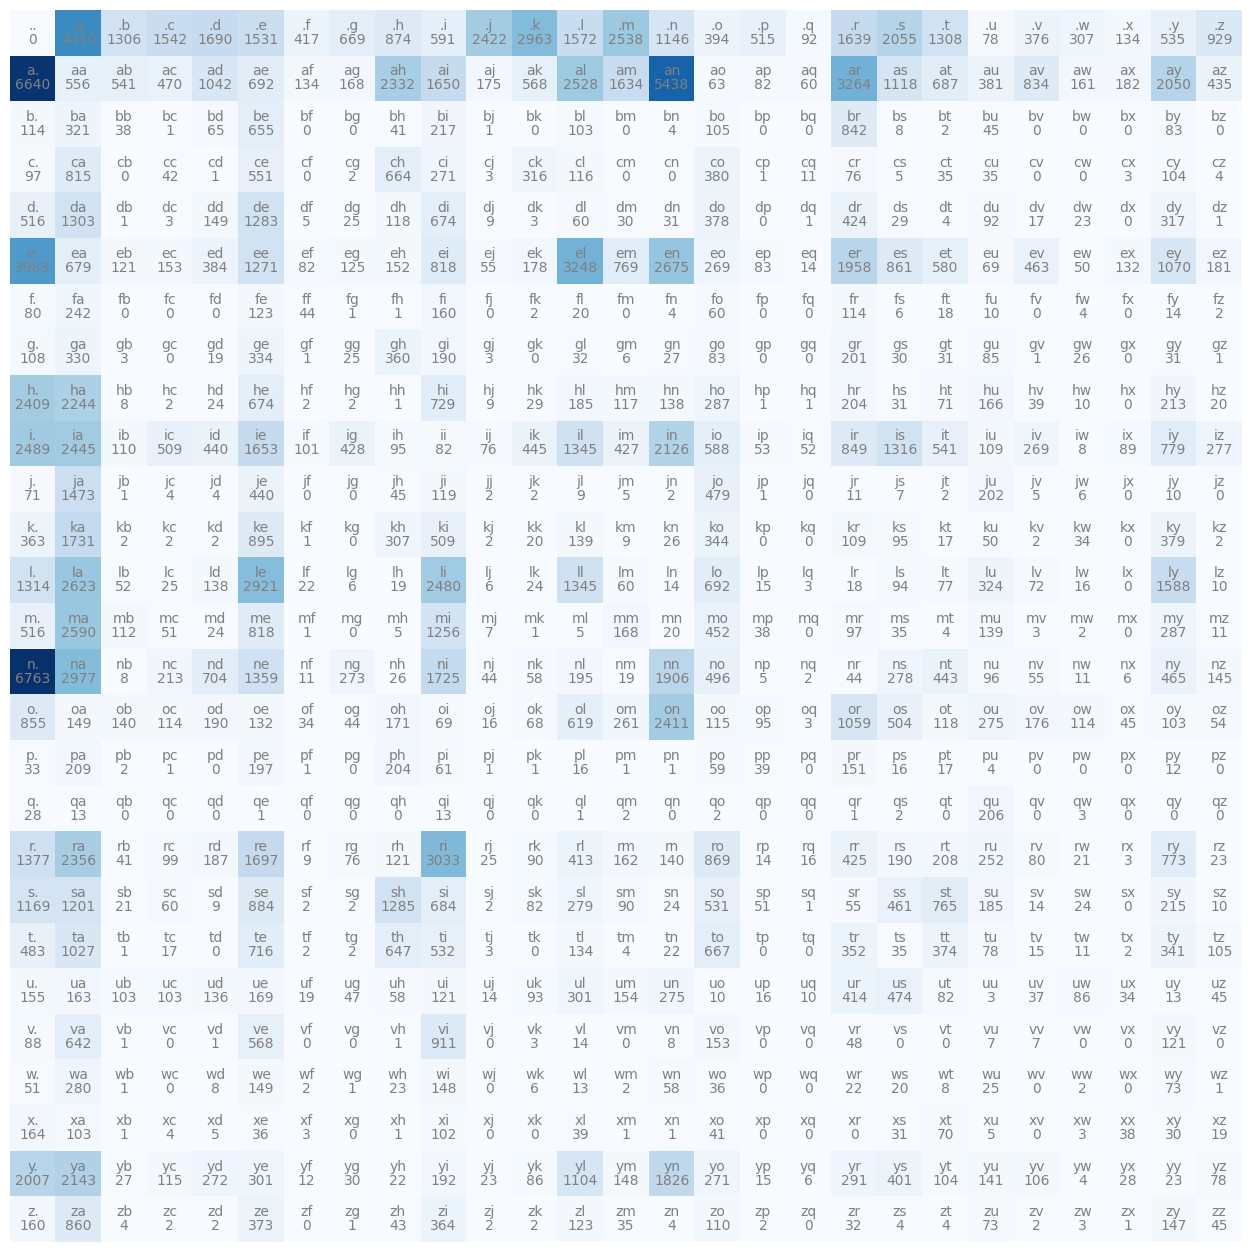

In [7]:
# Plot the biagrams of the dataset
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [8]:
# Broadcasting: Normalise, but be careful, we need to normalise the rows, not the columns
P = (N+1).float()
P /= P.sum(1, keepdims=True)

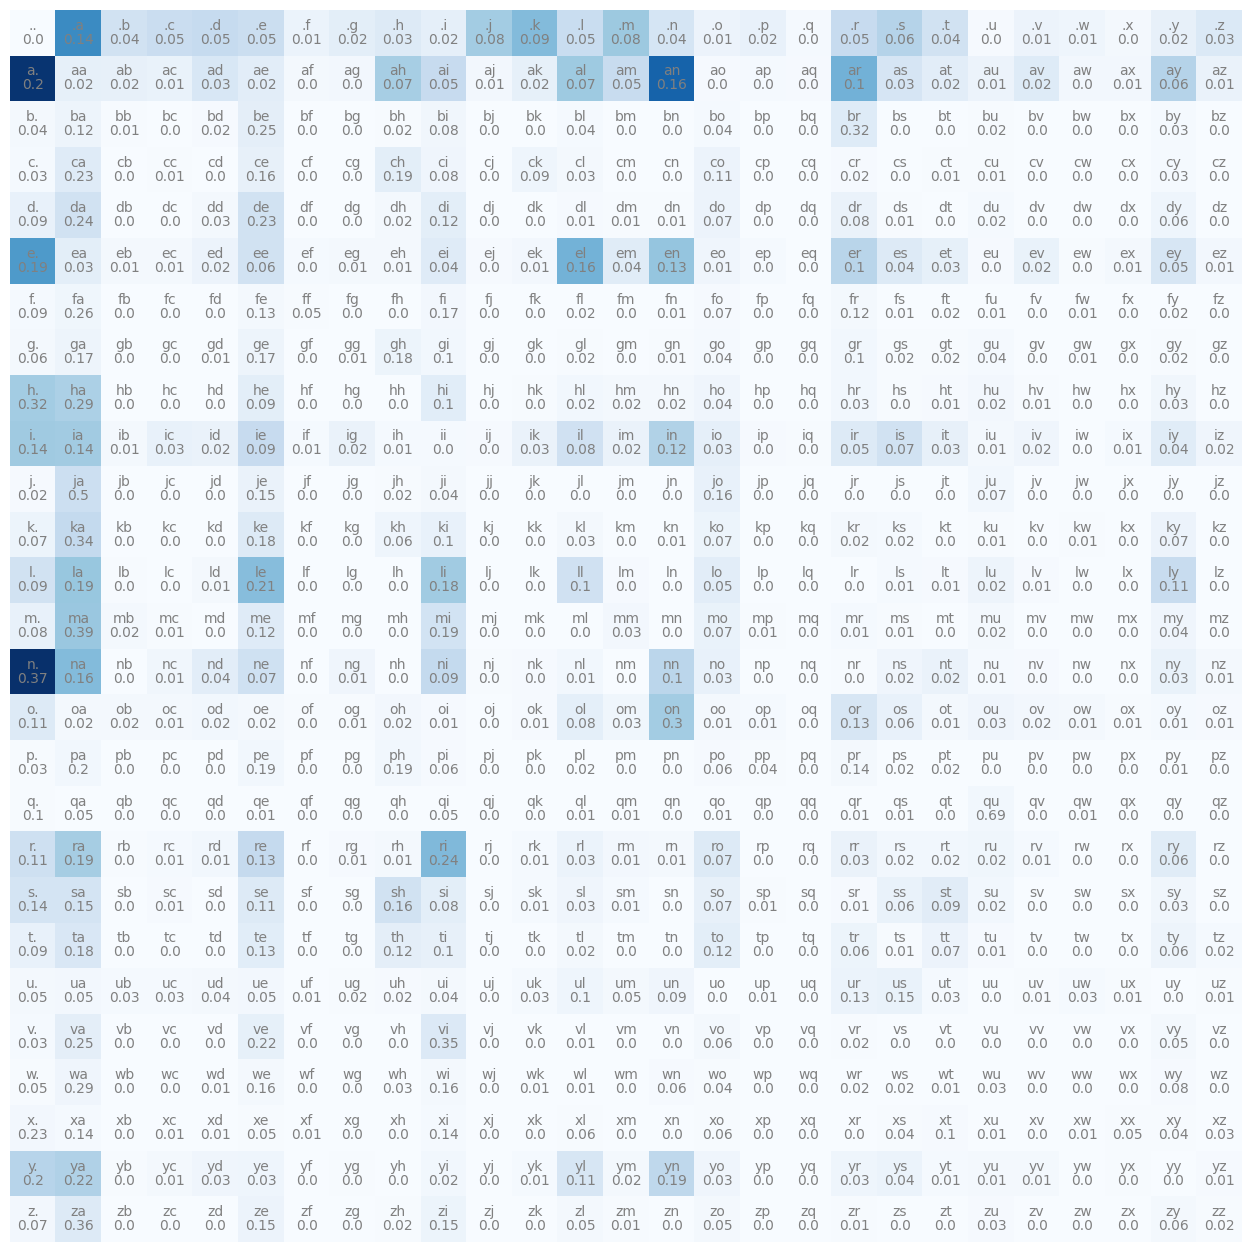

In [9]:
# Plot the biagrams of the dataset
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, round(P[i, j].item(),2), ha="center", va="top", color='gray')
plt.axis('off');

In [10]:
# Sample randomly the next letters over the distribution from the train set until the end symbol is reached
# Set the seed for reproducibility
g = torch.Generator().manual_seed(2147483647)
# Sample 5 names
for i in range(5):
  out = []
  ix = 0
  while True:
    p = P[ix]
    # Pick next letter based on the distribution for the next letter from the row of the current letter
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    # Until end is reached
    if ix == 0:
      break
  print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


## 2. Evaluate quality of model

The idea is that the model is good, if it predicts the next letter with high probability. An untrained model would predict every letter with a probability of 1/27.

In [11]:
# GOAL: maximize likelihood of the data w.r.t. model parameters (statistical modeling)
# equivalent to maximizing the log likelihood (because log is monotonic)
# equivalent to minimizing the negative log likelihood
# equivalent to minimizing the average negative log likelihood

# log(a*b*c) = log(a) + log(b) + log(c)

In [12]:
# Get probability of all possible biagrams in the dataset
# We want to get the likelihood of the data, i.e. the probability the model assigns to the data
# This should be high if the model is good
# To get one number we need to multiply all the probabilities of all the biagrams in the dataset
# But we can use the log trick to convert the product into a sum
# The log also helps to avoid underflow, meaning to avoid very small numbers
# Add the end, we want to minimize the negative log likelihood, which is equivalent to maximizing the log likelihood

log_likelihood = 0.0
n = 0
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')
print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


## 3. Test NN with first word without optimisation

In [13]:
# Create the training set of bigrams (x,y)
# Two lists, one for x (current letter) and one for y (next letter)
xs, ys = [], []

# Example for first word
for w in words[:1]:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [14]:
# Encode integers via one-hot encoding to be able to insert them to the NN
xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [18]:
# Example with one neuron
# Create first random weights
W = torch.randn((27, 1))

# Multiply the one-hot encoded input with the weights
xenc @ W    # (5, 27) @ (27, 1) = (5, 1)

# Get the probabilities by applying the softmax function
logits = xenc @ W # log-counts
counts = logits.exp() # equivalent N
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [21]:
# Randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)    # 1 layer, 27 neurons, 27 inputs

In [22]:
# Compute the probabilities of the next character
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'
probs

tensor([[0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
         0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
         0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
        [0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
         0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
         0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0312, 0.0737, 0.0484, 0.0333, 0.0674, 0.0200, 0.0263, 0.0249, 0.1226,
         0.0164, 0.0075, 0.0789, 0.0131, 0.0267, 0.0147, 0.0112, 0.0585, 0.0121,
         0.0650, 0.0058, 0.0208, 0.0078, 0.0133, 0.0203, 0.1204, 0.0469, 0.0126],
        [0.0150, 0.0086,

In [23]:
# 5 radomly examples from the first word in the dataset
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.012286253273487091
log likelihood: -4.3992743492126465
negative log likelihood: 4.3992743492126465
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character:

## 4. Test NN with first word with optimisation

In [62]:
# Try a random different W
# Randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) # requires_grad=True: we want to compute gradients for W

In [68]:
# Forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

print(loss.item())

3.7492129802703857


In [69]:
W.grad[0]

tensor([ 0.0121,  0.0020,  0.0025,  0.0008,  0.0034, -0.1975,  0.0005,  0.0046,
         0.0027,  0.0063,  0.0016,  0.0056,  0.0018,  0.0016,  0.0100,  0.0476,
         0.0121,  0.0005,  0.0050,  0.0011,  0.0068,  0.0022,  0.0006,  0.0040,
         0.0024,  0.0307,  0.0292])

In [70]:
# Backward pass
W.grad = None # set to zero the gradient
loss.backward()

In [71]:
W.grad[0]

tensor([ 0.0121,  0.0020,  0.0025,  0.0008,  0.0034, -0.1975,  0.0005,  0.0046,
         0.0027,  0.0063,  0.0016,  0.0056,  0.0018,  0.0016,  0.0100,  0.0474,
         0.0121,  0.0005,  0.0050,  0.0011,  0.0068,  0.0022,  0.0006,  0.0040,
         0.0024,  0.0307,  0.0292])

In [72]:
# Update the weights
W.data += -0.1 * W.grad

## 5. Full optimisation

In [73]:
# Create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [75]:
# Gradient descent
# We want to get to something below 2.47, as above with probabilities
for k in range(50):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts. It basically gives the row of the matrix W corresponding to the input character in the one-hot encoding
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # Get loss over the biagrams in the dataset and add a regularization term to avoid weights to grow too much
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

3.3788065910339355
3.161090850830078
3.027186155319214
2.9344842433929443
2.867231607437134
2.8166542053222656
2.777146339416504
2.7452542781829834
2.7188305854797363
2.696505308151245
2.6773722171783447
2.6608054637908936
2.6463515758514404
2.633664846420288
2.622471570968628
2.6125476360321045
2.6037068367004395
2.595794916152954
2.5886809825897217
2.5822560787200928
2.576429843902588
2.5711236000061035
2.566272735595703
2.5618228912353516
2.5577263832092285
2.5539441108703613
2.5504424571990967
2.5471925735473633
2.5441696643829346
2.5413525104522705
2.538721799850464
2.536262035369873
2.5339579582214355
2.5317976474761963
2.5297679901123047
2.527860164642334
2.5260636806488037
2.5243704319000244
2.522773027420044
2.521263837814331
2.519836902618408
2.5184857845306396
2.5172054767608643
2.515990734100342
2.5148372650146484
2.5137407779693604
2.51269793510437
2.511704921722412
2.5107579231262207
2.509854793548584


In [76]:
# Finally, sample from the 'neural net' model five names
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  out = []
  ix = 0 # We start with the start symbol
  while True:
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    # Until end symbol is reached
    if ix == 0:
      break
  print(''.join(out))

cexze.
mogllurailezityha.
konimittain.
llayn.
ka.
